### Resultados Votação

Neste notebook, calculamos os resultados finais da votação.

Serão realizadas 4 principais etapas de limpeza dos dados:

1. Join com a base de dados servidores ativos por meio dos RFs.

2. Remoção dos votos que foram feitos com RFs inexistentes ou que não correspondem a membros da carreira dos APPGs.

3. Identificação dos APPGGs que não votaram, mas estão na base de servidores ativos (abstenções).

4. Tratamento dos votos duplicados.

E 2 etapas de processamento:

1. Cálculo dos resultados gerais, contando faltantes e abstenções.

2. Cálculo dos resultados finais, apenas com votos válidos (sem contar faltantes e asbtenções).

In [1]:
import pandas as pd
from zipfile import ZipFile
import os
import requests
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set()
pd.set_option('display.max_columns', None)

#### Download da base mais recente de servidores ativos.

Dados extraídos do portal de dados abertos, no conjunto da relação de servidores ativos: http://dados.prefeitura.sp.gov.br/dataset/servidores-ativos-da-prefeitura


In [3]:
url = (
       'http://dados.prefeitura.sp.gov.br/'
       'dataset/bf5df0f4-4fb0-4a5e-b013-07d098cc7b1c/'
       'resource/40a9c9ef-55b9-41e3-9879-5f74b37b7352/'
       'download/verificadoativos02-05-2023abr-2023.csv'
      )

In [4]:
with requests.get(url) as r:
    csv_content = r.text

Checando para ver qual o separador

In [5]:
csv_content[:10]

'REGISTRO;V'

In [6]:
#vou salvar para subir no repositório para efeitos de transparência
#podia apenas ter abrido no pandas direto usando StringIO
with open('servidores_ativos_abril_2023.csv', 'w', encoding='utf-8') as f:
    f.write(csv_content)

In [7]:
servidores = pd.read_csv('servidores_ativos_abril_2023.csv', sep=';')    

In [8]:
servidores.head()

,REGISTRO,VINCULO,NOME,CARGO_BASICO,REF_CARGO_BAS,SEGMENTO,GRUPO,SUBGRUPO,ESCOL_CARGO_BASICO,CARGO_COMISSAO,REF_CARGO_COM,ESCOL_CARGO_COMISSAO,JORNADA,DATA_INICIO_EXERC,REL_JUR_ADM,SECRET_SUBPREF,SETOR,ORGAO_EXT,SEXO,ANO_NASCIMENTO,RACA,DEFICIENTE
0,1145541,16,CLEUZA BORGES PEREIRA SILVA,ASSESSOR IV,CDA-4,NaN,QC,CARGO EM COMISSAO,NAO SE APLICA,NaN,NaN,NaN,40 H,01/06/2022,EM COMISSAO,SECRETARIA MUNICIPAL DE GESTAO,ASSESSORIA JURIDICA,NaN,F,1949,PARDA,NAO
1,1154231,2,IOLANDA RIGON,FISCAL DE POSTURAS MUNICIPAIS NIVEL III,QFPM14,NaN,QFPM,SUPERIOR,SUPERIOR COMPLETO,NaN,NaN,NaN,40 H,07/10/1992,EFETIVO,SUBPREFEITURA LAPA,UNIDADE TECNICA DE FISCALIZACAO,NaN,F,1949,BRANCA,NAO
2,1159470,2,JOSE EDUARDO SOARES DE CASTRO,ANALISTA DE INFORMACOES CULTURA E DESPORTO (NQ...,QDHS17,BIBLIOTECONOMIA,QDHS,SUPERIOR,SUPERIOR COMPLETO,NaN,NaN,NaN,40 H,13/08/1982,EFETIVO,PROCURADORIA GERAL DO MUNICIPIO,CENTRO ESTUDOS JURIDICOS - CEJUR,NaN,M,1951,BRANCA,NAO
3,1160478,2,JULIO DE CARVALHO,FISCAL DE POSTURAS MUNICIPAIS NIVEL III,QFPM13,NaN,QFPM,SUPERIOR,SUPERIOR COMPLETO,NaN,NaN,NaN,40 H,15/12/1981,EFETIVO,SUBPREFEITURA SANTANA/TUCURUVI,SUPERVISÃO TECNICA DE FISCALIZACAO,NaN,M,1951,BRANCA,NAO
4,1161181,9,NEUSA PEDRAO NASSIR,ASSESSOR V,CDA-5,NaN,QC,CARGO EM COMISSAO,NAO SE APLICA,NaN,NaN,NaN,40 H,01/06/2022,EM COMISSAO,SECRETARIA DO GOVERNO MUNICIPAL,ASSESSORIA JURIDICA,NaN,F,1947,BRANCA,NAO


#### Identificação dos membros da carreira

A seguir filtramos a base de servidores para identificar os membros da carreira dos APPGGs.

In [9]:
cargos_unicos = servidores['CARGO_BASICO'].unique()

Buscando o nome exato do cargo para filtrar

In [10]:
[cargo for cargo in cargos_unicos if 'politicas' in str(cargo).lower()]

['ASSISTENTE DE GESTAO DE POLITICAS PUBLICAS NIVEL II',
 'ASSISTENTE DE GESTAO DE POLITICAS PUBLICAS NIVEL I',
 'ANALISTA POLITICAS PUBLICAS GESTAO GOVERNAMENTAL N.I']

In [11]:
cargo_appgg = 'ANALISTA POLITICAS PUBLICAS GESTAO GOVERNAMENTAL N.I'

In [12]:
filtro_appggs = servidores['CARGO_BASICO']==cargo_appgg

In [13]:
filtro_appggs.sum()

142

In [14]:
appggs = servidores[filtro_appggs].copy().reset_index(drop=True)

In [15]:
appggs.head()

,REGISTRO,VINCULO,NOME,CARGO_BASICO,REF_CARGO_BAS,SEGMENTO,GRUPO,SUBGRUPO,ESCOL_CARGO_BASICO,CARGO_COMISSAO,REF_CARGO_COM,ESCOL_CARGO_COMISSAO,JORNADA,DATA_INICIO_EXERC,REL_JUR_ADM,SECRET_SUBPREF,SETOR,ORGAO_EXT,SEXO,ANO_NASCIMENTO,RACA,DEFICIENTE
0,6394604,3,CLAUDIO AGUIAR ALMEIDA,ANALISTA POLITICAS PUBLICAS GESTAO GOVERNAMENT...,APPGG1,NaN,QPGG,SUPERIOR,SUPERIOR COMPLETO,NaN,NaN,NaN,40 H,01/10/2021,EFETIVO,SECRETARIA MUNICIPAL DE CULTURA,SECRETARIA MUNICIPAL DE CULTURA,NaN,M,1963,PRETA,NAO
1,7575491,2,MAURICIO DA SILVA CORREIA,ANALISTA POLITICAS PUBLICAS GESTAO GOVERNAMENT...,APPGG1,NaN,QPGG,SUPERIOR,SUPERIOR COMPLETO,NaN,NaN,NaN,40 H,03/11/2021,EFETIVO,SECRETARIA MUNICIPAL DE GESTAO,SECRETARIA MUNICIPAL DE GESTAO,PREFEITURA MUNICIPAL DE SALVADOR - BA,M,1986,BRANCA,NAO
2,7718543,6,MARCIA MIYUKI ISHIKAWA,ANALISTA POLITICAS PUBLICAS GESTAO GOVERNAMENT...,APPGG1,NaN,QPGG,SUPERIOR,SUPERIOR COMPLETO,NaN,NaN,NaN,40 H,08/12/2021,EFETIVO,SECRETARIA MUNICIPAL DE HABITACAO,GABINETE DO SECRETARIO,NaN,F,1978,BRANCA,NAO
3,7794720,2,TIAGO ROSA MACHADO,ANALISTA POLITICAS PUBLICAS GESTAO GOVERNAMENT...,APPGG1,NaN,QPGG,SUPERIOR,SUPERIOR COMPLETO,NaN,NaN,NaN,40 H,05/01/2022,EFETIVO,SECRETARIA MUNICIPAL DE ESPORTES E LAZER,SECRETARIA MUNICIPAL DE ESPORTES E LAZER,NaN,M,1983,BRANCA,NAO
4,7809948,3,LUIZ CARLOS LOPES,ANALISTA POLITICAS PUBLICAS GESTAO GOVERNAMENT...,APPGG3,NaN,QPGG,SUPERIOR,SUPERIOR COMPLETO,NaN,NaN,NaN,40 H,11/07/2016,EFETIVO,SECRETARIA MUNICIPAL DA PESSOA COM DEFICIENCIA,SECRETARIA MUNICIPAL DA PESSOA COM DEFICIENCIA,NaN,M,1962,BRANCA,SIM


In [16]:
appggs.to_csv('relacao_appggs.csv', encoding='utf-8', sep=';', index=False)

#### Dados votação

Agora vamos abrir os resultados da votação

In [17]:
with ZipFile("Emendas Carreira APPG - PL 328_2023.csv.zip") as arq_zip:
    arq_zip.extractall()

In [18]:
arq_votos = os.path.join("Emendas Carreira APPG - PL 328", "2023.csv")

In [19]:
votos = pd.read_csv(arq_votos)

In [20]:
votos.head()

,Timestamp,RF,"Em relação às propostas de recuperação salarial, você:",Em relação à proposta de remoção da cláusula de limite para as cessões sem prejuízo dos vencimentos você:,Em relação à proposta de remoção da cláusula de impedimento de ocupar cargos em comissão durante o estágio probatório você:
0,2023/06/16 2:40:20 PM GMT-3,8390452,Concorda com a proposta de reversão do achatam...,Discorda.,NaN
1,2023/06/16 2:44:03 PM GMT-3,8359091,Concorda com a proposta de reversão do achatam...,Concorda.,NaN
2,2023/06/16 2:46:22 PM GMT-3,8084858,Concorda com a proposta de unificação do quadr...,Concorda.,Concorda.
3,2023/06/16 2:49:59 PM GMT-3,8475024,Concorda com a proposta de reversão do achatam...,Concorda.,Concorda.
4,2023/06/16 3:07:59 PM GMT-3,8390452,Concorda com a proposta de reversão do achatam...,Discorda.,Concorda.


#### Join

Agora vamos fazer join das duas bases, com dados de interesse sobre a carreira.

In [21]:
dados_appggs = [
                'REGISTRO', 
                'NOME', 
                'CARGO_COMISSAO', 
                'SECRET_SUBPREF', 
                'DATA_INICIO_EXERC',
                'ORGAO_EXT',
                'SEXO',
                'RACA',
                'DEFICIENTE'
]

In [22]:
appggs = appggs[dados_appggs].copy()

In [23]:
votos['RF'].isnull().any()

False

In [24]:
appggs['REGISTRO'].isnull().any()

False

In [25]:
votos['RF'] = votos['RF'].astype(str)

In [26]:
appggs['REGISTRO'] = appggs['REGISTRO'].astype(str)

In [27]:
votos_join = pd.merge(votos, appggs, how='outer', left_on='RF', right_on='REGISTRO')

In [28]:
votos_join.head()

,Timestamp,RF,"Em relação às propostas de recuperação salarial, você:",Em relação à proposta de remoção da cláusula de limite para as cessões sem prejuízo dos vencimentos você:,Em relação à proposta de remoção da cláusula de impedimento de ocupar cargos em comissão durante o estágio probatório você:,REGISTRO,NOME,CARGO_COMISSAO,SECRET_SUBPREF,DATA_INICIO_EXERC,ORGAO_EXT,SEXO,RACA,DEFICIENTE
0,2023/06/16 2:40:20 PM GMT-3,8390452,Concorda com a proposta de reversão do achatam...,Discorda.,NaN,8390452,BRUNO MARTINELLI,NaN,SECRETARIA MUNICIPAL DE INOVACAO E TECNOLOGIA,15/10/2021,NaN,M,BRANCA,SIM
1,2023/06/16 3:07:59 PM GMT-3,8390452,Concorda com a proposta de reversão do achatam...,Discorda.,Concorda.,8390452,BRUNO MARTINELLI,NaN,SECRETARIA MUNICIPAL DE INOVACAO E TECNOLOGIA,15/10/2021,NaN,M,BRANCA,SIM
2,2023/06/17 6:52:49 PM GMT-3,8390452,Concorda com a proposta de unificação do quadr...,Discorda.,Concorda.,8390452,BRUNO MARTINELLI,NaN,SECRETARIA MUNICIPAL DE INOVACAO E TECNOLOGIA,15/10/2021,NaN,M,BRANCA,SIM
3,2023/06/16 2:44:03 PM GMT-3,8359091,Concorda com a proposta de reversão do achatam...,Concorda.,NaN,8359091,DANIEL BRUNO GARCIA,NaN,GABINETE DO PREFEITO,22/06/2016,NaN,M,BRANCA,NAO
4,2023/06/16 4:23:26 PM GMT-3,8359091,Concorda com a proposta de reversão do achatam...,Concorda.,Concorda.,8359091,DANIEL BRUNO GARCIA,NaN,GABINETE DO PREFEITO,22/06/2016,NaN,M,BRANCA,NAO


### Identificação abstenção

Como fizemos um outer join, os dados que estiverem com "nulo" nas colunas da base de votos são os appggs que não votaram.

In [29]:
votos_join['RF'].isnull().sum()

78

In [30]:
votos_join['REGISTRO'].isnull().sum()

7

Alguns RFs da base de votos não foram encontrados - o que é natural, trata-se da taxa de abstenção.

No entanto, temos também valores nulos para o RF da base de APPGGs. Isso indica que houve RFs digitados que não existem.

Teremos que anular esses votos.

In [31]:
rfs_inexistentes = votos_join['REGISTRO'].isnull()

In [32]:
votos_join['rf_inexistente'] = rfs_inexistentes

In [33]:
anulados_rf_inexistente = votos_join[rfs_inexistentes].copy().reset_index(drop=True)

In [34]:
#como todas as colunas da base de servidores são nulas, vou manter apeans a da base de votos
anulados_rf_inexistente = anulados_rf_inexistente[votos.columns]

In [35]:
anulados_rf_inexistente

,Timestamp,RF,"Em relação às propostas de recuperação salarial, você:",Em relação à proposta de remoção da cláusula de limite para as cessões sem prejuízo dos vencimentos você:,Em relação à proposta de remoção da cláusula de impedimento de ocupar cargos em comissão durante o estágio probatório você:
0,2023/06/16 3:54:36 PM GMT-3,8907521,Concorda com a proposta de unificação do quadr...,Discorda.,Concorda.
1,2023/06/16 4:41:40 PM GMT-3,8359592,Concorda com a proposta de reversão do achatam...,Concorda.,Prefere se abster de votar.
2,2023/06/16 4:43:25 PM GMT-3,8359167,Concorda com a proposta de unificação do quadr...,Concorda.,Concorda.
3,2023/06/16 6:08:57 PM GMT-3,8897017,Concorda com a proposta de reversão do achatam...,Concorda.,Discorda.
4,2023/06/16 9:16:46 PM GMT-3,8321854,Concorda com a proposta de unificação do quadr...,Concorda.,Concorda.
5,2023/06/17 9:56:25 AM GMT-3,8111818,Concorda com a proposta de unificação do quadr...,Concorda.,Concorda.
6,2023/06/17 6:02:36 PM GMT-3,8414111,Concorda com a proposta de reversão do achatam...,Concorda.,Concorda.


In [36]:
anulados_rf_inexistente.to_csv('anulados_rf_inexistente.csv', sep=';', encoding='utf-8')

### Tratamento votos duplicados

Vamos ver agora se houve votos duplicados.

Esses votos podem ser identificados por uma duplicação na coluna "RF" que identifica o RF do votante.

In [37]:
votos_submetidos = votos_join['RF'].notnull()

Vou aproveitar para criar uma coluna de abstencao (que é, logicamente, a negação da coluna de voto submetido)

In [38]:
votos_join['abstencao'] = ~votos_submetidos

Há quatro votos duplicados.

In [39]:
votos_join[votos_submetidos]['RF'].duplicated().sum()

4

O voto duplicado deve ser assim aquele voto que foi submetido e que está com o RF duplicado.

Abaixo identificamos eles.

In [40]:
votos_join['voto_duplicado'] = votos_submetidos & votos_join['RF'].duplicated(keep=False)

In [41]:
votos_join[votos_join['voto_duplicado']]

,Timestamp,RF,"Em relação às propostas de recuperação salarial, você:",Em relação à proposta de remoção da cláusula de limite para as cessões sem prejuízo dos vencimentos você:,Em relação à proposta de remoção da cláusula de impedimento de ocupar cargos em comissão durante o estágio probatório você:,REGISTRO,NOME,CARGO_COMISSAO,SECRET_SUBPREF,DATA_INICIO_EXERC,ORGAO_EXT,SEXO,RACA,DEFICIENTE,rf_inexistente,abstencao,voto_duplicado
0,2023/06/16 2:40:20 PM GMT-3,8390452,Concorda com a proposta de reversão do achatam...,Discorda.,NaN,8390452,BRUNO MARTINELLI,NaN,SECRETARIA MUNICIPAL DE INOVACAO E TECNOLOGIA,15/10/2021,NaN,M,BRANCA,SIM,False,False,True
1,2023/06/16 3:07:59 PM GMT-3,8390452,Concorda com a proposta de reversão do achatam...,Discorda.,Concorda.,8390452,BRUNO MARTINELLI,NaN,SECRETARIA MUNICIPAL DE INOVACAO E TECNOLOGIA,15/10/2021,NaN,M,BRANCA,SIM,False,False,True
2,2023/06/17 6:52:49 PM GMT-3,8390452,Concorda com a proposta de unificação do quadr...,Discorda.,Concorda.,8390452,BRUNO MARTINELLI,NaN,SECRETARIA MUNICIPAL DE INOVACAO E TECNOLOGIA,15/10/2021,NaN,M,BRANCA,SIM,False,False,True
3,2023/06/16 2:44:03 PM GMT-3,8359091,Concorda com a proposta de reversão do achatam...,Concorda.,NaN,8359091,DANIEL BRUNO GARCIA,NaN,GABINETE DO PREFEITO,22/06/2016,NaN,M,BRANCA,NAO,False,False,True
4,2023/06/16 4:23:26 PM GMT-3,8359091,Concorda com a proposta de reversão do achatam...,Concorda.,Concorda.,8359091,DANIEL BRUNO GARCIA,NaN,GABINETE DO PREFEITO,22/06/2016,NaN,M,BRANCA,NAO,False,False,True
6,2023/06/16 2:49:59 PM GMT-3,8475024,Concorda com a proposta de reversão do achatam...,Concorda.,Concorda.,8475024,RODOLFO FREIRE MAICHE,NaN,SECRETARIA MUNICIPAL DO VERDE E DO MEIO AMBIENTE,09/01/2018,NaN,M,PRETA,NAO,False,False,True
7,2023/06/16 4:21:37 PM GMT-3,8475024,Concorda com a proposta de unificação do quadr...,Concorda.,Concorda.,8475024,RODOLFO FREIRE MAICHE,NaN,SECRETARIA MUNICIPAL DO VERDE E DO MEIO AMBIENTE,09/01/2018,NaN,M,PRETA,NAO,False,False,True


In [42]:
duplicados = votos_join[votos_join['voto_duplicado']]

Abaixo checo se algum voto duplicado é de fato duplicado ou se houve uma mudança na votação.

Tenho que desconsiderar a coluna de timestamp, porque ela certamente muda de um registro para outro.

Como vemos, não há linha inteiramente duplicada, de modo que houve mudança no voto dos votos duplicados.

In [43]:
duplicados.drop('Timestamp', axis=1).duplicated().any()

False

In [44]:
votos_join['Timestamp'].dtype

dtype('O')

In [45]:
votos_join['Timestamp'] = pd.to_datetime(votos_join['Timestamp'])

Tivemos votos ao longo do fim de semana (o que é ok, só fechei a votação hoje de manhã).

In [46]:
votos_join['Timestamp'].dt.day.unique()

array([16., 17., 18., nan])

In [47]:
votos_join['Timestamp'].dt.month.unique()

array([ 6., nan])

Vou ordenar os votos pela ordem inversa da hora de registro (ou seja, os últimos votos primeiro).

In [48]:
votos_join.sort_values(by='Timestamp', ascending=False, inplace=True)

In [49]:
votos_join.head()

,Timestamp,RF,"Em relação às propostas de recuperação salarial, você:",Em relação à proposta de remoção da cláusula de limite para as cessões sem prejuízo dos vencimentos você:,Em relação à proposta de remoção da cláusula de impedimento de ocupar cargos em comissão durante o estágio probatório você:,REGISTRO,NOME,CARGO_COMISSAO,SECRET_SUBPREF,DATA_INICIO_EXERC,ORGAO_EXT,SEXO,RACA,DEFICIENTE,rf_inexistente,abstencao,voto_duplicado
74,2023-06-18 01:01:46+03:00,8896968,Concorda com a proposta de unificação do quadr...,Concorda.,Concorda.,8896968,JOAO BONETT NETO,NaN,SECRETARIA MUNICIPAL DE MOBILIDADE E TRANSITO,14/10/2021,NaN,M,BRANCA,NAO,False,False,False
73,2023-06-18 00:14:03+03:00,8358931,Concorda com a proposta de unificação do quadr...,Concorda.,Concorda.,8358931,LIA PALM,COORDENADOR II,SECRETARIA MUNICIPAL DE DESENVOLVIMENTO ECONOMICO,24/06/2016,NaN,F,BRANCA,NAO,False,False,False
72,2023-06-17 20:28:21+03:00,8894221,Concorda com a proposta de unificação do quadr...,Prefere se abster de votar.,Concorda.,8894221,LEANDRO DANIEL SANTOS CARVALHO,NaN,SECRETARIA MUNICIPAL DE EDUCACAO,03/11/2021,NaN,M,BRANCA,NAO,False,False,False
71,2023-06-17 20:18:21+03:00,8907536,Concorda com a proposta de unificação do quadr...,Concorda.,Concorda.,8907536,KIM FERREIRA DE SOUZA,NaN,SECRETARIA DO GOVERNO MUNICIPAL,17/12/2021,NaN,M,BRANCA,NAO,False,False,False
2,2023-06-17 18:52:49+03:00,8390452,Concorda com a proposta de unificação do quadr...,Discorda.,Concorda.,8390452,BRUNO MARTINELLI,NaN,SECRETARIA MUNICIPAL DE INOVACAO E TECNOLOGIA,15/10/2021,NaN,M,BRANCA,SIM,False,False,True


In [50]:
votos_join = votos_join.reset_index(drop=True)

Checando se o primeiro voto é de fato o último a ser registrado.

In [51]:
votos_join.loc[0,'Timestamp']==votos_join['Timestamp'].max()

True

Agora preciso preencher o RF dos faltantes. Por que se não o valor "nulo" seria identificado como um valor duplicado.

In [52]:
votos_join['RF'] = votos_join.apply(lambda row: row['RF'] if not pd.isnull(row['RF'])
                                   else row['REGISTRO'], axis=1)

In [53]:
votos_join['RF'].isnull().any()

False

Assim ficamos com os 4 votos duplicados de anteriormente

In [54]:
votos_join['RF'].duplicated().sum()

4

E podemos dropá-los, mantendo apenas o primeiro (que será o último voto feito, de acordo com nosso ordenamento).

In [55]:
votos_join = votos_join.drop_duplicates('RF', keep='first')

In [56]:
votos_join['RF'].duplicated().any()

False

Os votos que foram mantidos são aqueles cujo RF está na relação de votos duplicados.

In [57]:
duplicados

,Timestamp,RF,"Em relação às propostas de recuperação salarial, você:",Em relação à proposta de remoção da cláusula de limite para as cessões sem prejuízo dos vencimentos você:,Em relação à proposta de remoção da cláusula de impedimento de ocupar cargos em comissão durante o estágio probatório você:,REGISTRO,NOME,CARGO_COMISSAO,SECRET_SUBPREF,DATA_INICIO_EXERC,ORGAO_EXT,SEXO,RACA,DEFICIENTE,rf_inexistente,abstencao,voto_duplicado
0,2023/06/16 2:40:20 PM GMT-3,8390452,Concorda com a proposta de reversão do achatam...,Discorda.,NaN,8390452,BRUNO MARTINELLI,NaN,SECRETARIA MUNICIPAL DE INOVACAO E TECNOLOGIA,15/10/2021,NaN,M,BRANCA,SIM,False,False,True
1,2023/06/16 3:07:59 PM GMT-3,8390452,Concorda com a proposta de reversão do achatam...,Discorda.,Concorda.,8390452,BRUNO MARTINELLI,NaN,SECRETARIA MUNICIPAL DE INOVACAO E TECNOLOGIA,15/10/2021,NaN,M,BRANCA,SIM,False,False,True
2,2023/06/17 6:52:49 PM GMT-3,8390452,Concorda com a proposta de unificação do quadr...,Discorda.,Concorda.,8390452,BRUNO MARTINELLI,NaN,SECRETARIA MUNICIPAL DE INOVACAO E TECNOLOGIA,15/10/2021,NaN,M,BRANCA,SIM,False,False,True
3,2023/06/16 2:44:03 PM GMT-3,8359091,Concorda com a proposta de reversão do achatam...,Concorda.,NaN,8359091,DANIEL BRUNO GARCIA,NaN,GABINETE DO PREFEITO,22/06/2016,NaN,M,BRANCA,NAO,False,False,True
4,2023/06/16 4:23:26 PM GMT-3,8359091,Concorda com a proposta de reversão do achatam...,Concorda.,Concorda.,8359091,DANIEL BRUNO GARCIA,NaN,GABINETE DO PREFEITO,22/06/2016,NaN,M,BRANCA,NAO,False,False,True
6,2023/06/16 2:49:59 PM GMT-3,8475024,Concorda com a proposta de reversão do achatam...,Concorda.,Concorda.,8475024,RODOLFO FREIRE MAICHE,NaN,SECRETARIA MUNICIPAL DO VERDE E DO MEIO AMBIENTE,09/01/2018,NaN,M,PRETA,NAO,False,False,True
7,2023/06/16 4:21:37 PM GMT-3,8475024,Concorda com a proposta de unificação do quadr...,Concorda.,Concorda.,8475024,RODOLFO FREIRE MAICHE,NaN,SECRETARIA MUNICIPAL DO VERDE E DO MEIO AMBIENTE,09/01/2018,NaN,M,PRETA,NAO,False,False,True


In [58]:
#preciso soh converter essa coluna para datetime
duplicados['Timestamp'] = pd.to_datetime(duplicados['Timestamp'])

Agora, vamos checar se os votos que ficaram são sempre mais recentes (ou seja, com um timestamp maior) do que os votos duplicados para aquele RF.

In [59]:
ficaram = votos_join['RF'].isin(duplicados['RF'])

In [60]:
votos_ficaram = votos_join[ficaram]

In [61]:
for i, row in votos_ficaram.iterrows():
    
    #votos duplicados correspondentes ao RF
    duplidado_rf = duplicados[duplicados['RF']==row['RF']]
    
    assert (duplidado_rf['Timestamp'] <= row['Timestamp']).all()

In [62]:
votos_join['voto_duplicad_mantido'] = ficaram

In [63]:
(votos_join['voto_duplicad_mantido'] == votos_join['voto_duplicado']).all()

True

In [64]:
#não preciso mais dessa coluna
votos_join.drop('voto_duplicado', axis=1, inplace=True)

Como podemos ver abaixo, foram mantidos 3 votos. Correspondentes aos RFs únicos dos votos duplicados (ou seja, apenas um voto por pessoa).

In [65]:
votos_join['voto_duplicad_mantido'].sum()

3

In [66]:
len(duplicados['RF'].unique())

3

In [67]:
set(duplicados['RF']) - set(votos_join[votos_join['voto_duplicad_mantido']]['RF'])

set()

In [68]:
duplicados.to_csv('votos_duplicados.csv', index=False, sep=';', encoding='utf-8')

### Imputando valor "ausentes" para os votos das pessoas ausentes

Agora vamos colocar um novo resultado que diz "ausência" para os votos das pessoas ausentesvotos_join

In [69]:
votos_join.columns

Index(['Timestamp', 'RF',
       'Em relação às propostas de recuperação salarial, você:',
       'Em relação à proposta de remoção da cláusula de limite para as cessões sem prejuízo dos vencimentos você:',
       'Em relação à proposta de remoção da cláusula de impedimento de ocupar cargos em comissão durante o estágio probatório você:',
       'REGISTRO', 'NOME', 'CARGO_COMISSAO', 'SECRET_SUBPREF',
       'DATA_INICIO_EXERC', 'ORGAO_EXT', 'SEXO', 'RACA', 'DEFICIENTE',
       'rf_inexistente', 'abstencao', 'voto_duplicad_mantido'],
      dtype='object')

In [70]:
cols_votos = [
    'Em relação às propostas de recuperação salarial, você:',
    'Em relação à proposta de remoção da cláusula de limite para as cessões sem prejuízo dos vencimentos você:',
    'Em relação à proposta de remoção da cláusula de impedimento de ocupar cargos em comissão durante o estágio probatório você:'
]

In [71]:
pd.DataFrame(votos_join[cols_votos].isnull().sum()).rename({0 : 'qtd_ausencias'}, axis=1)

,qtd_ausencias
"Em relação às propostas de recuperação salarial, você:",78
Em relação à proposta de remoção da cláusula de limite para as cessões sem prejuízo dos vencimentos você:,78
Em relação à proposta de remoção da cláusula de impedimento de ocupar cargos em comissão durante o estágio probatório você:,78


In [72]:
votos_join['abstencao'].sum()

78

In [73]:
for col in cols_votos:
    votos_join[col] = votos_join[col].apply(lambda x: x if not pd.isnull(x) else 'ausencia')

Agora resta apenas uma pequena limpeza nos valores nulos para cargo em comissao e orgao externo

In [74]:
votos_join['CARGO_COMISSAO'] = votos_join['CARGO_COMISSAO'].apply(
                                                lambda x: x if not pd.isnull(x) else 'nenhum')

In [75]:
votos_join['CARGO_COMISSAO'] = votos_join['ORGAO_EXT'].apply(
                                                lambda x: x if not pd.isnull(x) else 'nao')

In [76]:
df_final = votos_join.reset_index(drop=True).copy()

In [77]:
df_final.to_csv('dados_votacao_final.csv', sep=';', index=False, encoding='utf-8')

### Plotagem dos resultados finais

Para calcular os resultados finais, precisamos agrupar os dados por coluna.

As células abaixo mostram isso.

In [78]:
#coluna de contagem para facilitar os groupbys
df_final['count'] = 1

<AxesSubplot:title={'center':'Em relação às propostas de recuperação salarial, você:'}, ylabel='Em relação às propostas de recuperação salarial, você:'>

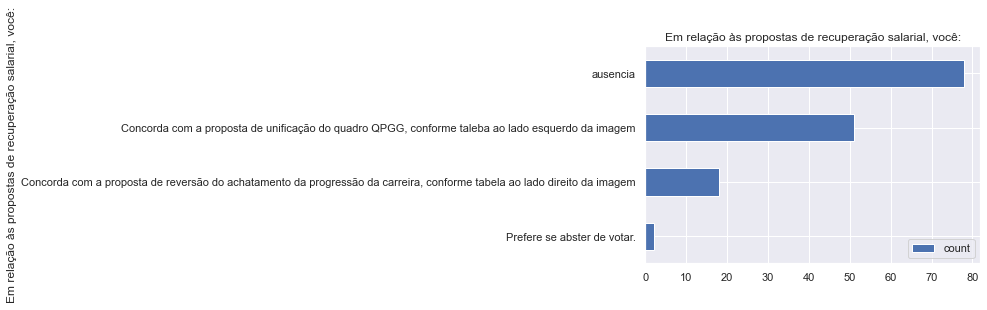

In [86]:
grouped = df_final.groupby(cols_votos[0]).sum()[['count']].sort_values(by='count')
grouped.plot.barh(title=cols_votos[0])

<AxesSubplot:title={'center':'Em relação à proposta de remoção da cláusula de limite para as cessões sem prejuízo dos vencimentos você:'}, ylabel='Em relação à proposta de remoção da cláusula de limite para as cessões sem prejuízo dos vencimentos você:'>

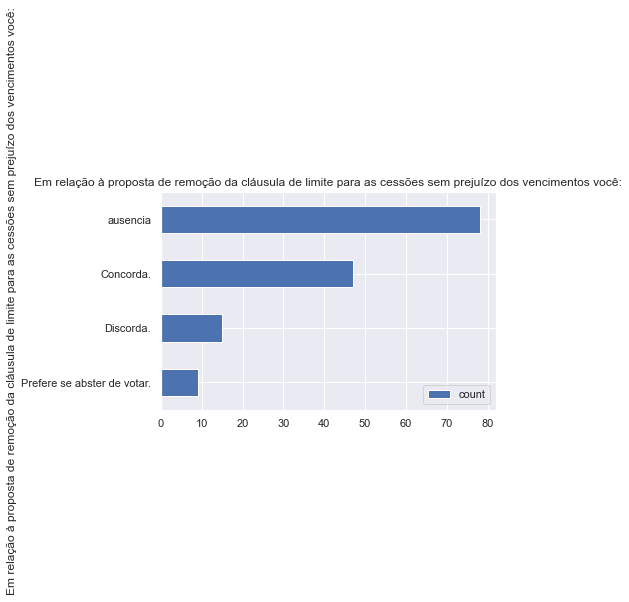

In [87]:
grouped = df_final.groupby(cols_votos[1]).sum()[['count']].sort_values(by='count')
grouped.plot.barh(title=cols_votos[1])

<AxesSubplot:title={'center':'Em relação à proposta de remoção da cláusula de impedimento de ocupar cargos em comissão durante o estágio probatório você:'}, ylabel='Em relação à proposta de remoção da cláusula de impedimento de ocupar cargos em comissão durante o estágio probatório você:'>

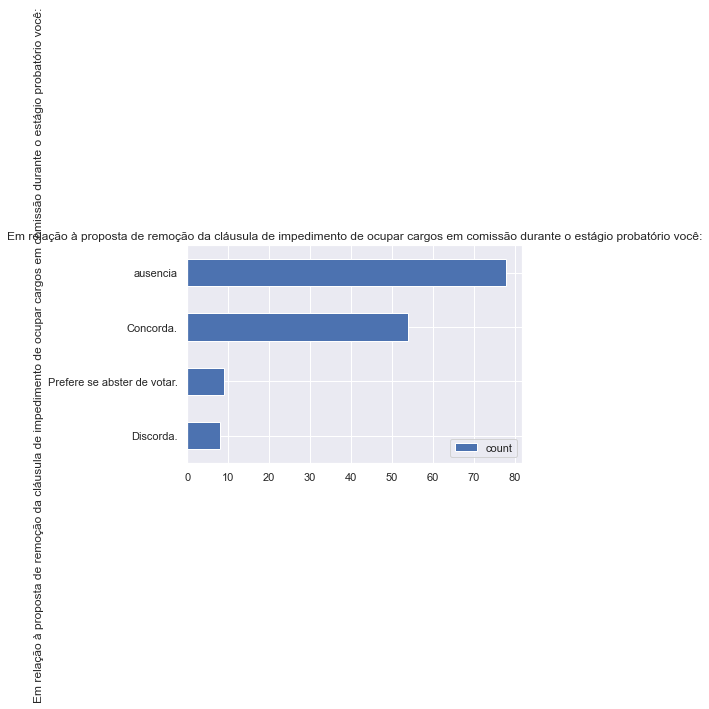

In [88]:
grouped = df_final.groupby(cols_votos[2]).sum()[['count']].sort_values(by='count')
grouped.plot.barh(title=cols_votos[2])

Mas a leitura fica muito ruim. Por isso, usarei uma ferramenta interativa.

In [82]:
(~df_final['abstencao']).sum()

71

In [83]:
df_final['abstencao'].mean()

0.5234899328859061

In [84]:
(~df_final['abstencao'] & ~df_final['rf_inexistente']).sum()

64